In [51]:
from functions import *
from random import sample
from htmldate import find_date
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import json
from langid.langid import LanguageIdentifier, model
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import random
import re
import langid
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re
from pylab import *

nlp = spacy.load('en_core_web_sm')

In [52]:
#base_path = "/media/ruben/Data Drive/react-data/protest/{}".format("selection")
base_path = "D:/react-data/protest/{}".format("selection2")

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin',binary=True)
model.init_sims(replace=True)

In [75]:
model.most_similar('Madrid')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Barcelona', 0.7255446910858154),
 ('Spain', 0.6743447780609131),
 ('Bilbao', 0.632834792137146),
 ('Malaga', 0.6034684181213379),
 ('Zaragoza', 0.6016265153884888),
 ('Catalan', 0.6015604734420776),
 ('Seville', 0.5968208312988281),
 ('Mallorca', 0.5876096487045288),
 ('Valencia', 0.575476884841919),
 ('Zapatero', 0.5682734251022339)]

In [53]:
# Get Publication Dates

dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

In [54]:
dt = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    num_iterations = len(num_iterations)

    start_iter = 1
    range_iter = [str(i) for i in list(range(1,num_iterations + 1))]

    folder_base = os.path.join(base_path,photo,photo)

    for iteration in range_iter:
        fn = os.path.join(folder_base + "_" +str(iteration),"txt", "parsed_text.json")
        with open(fn) as fp:
            pages = json.load(fp)
            
        for identifier,sentences in pages.items():
            
            sentences = [s.replace("\n","").lower() for s in sentences]
            sentences = [re.sub(' +', ' ', s) for s in sentences]

            url = identifier.split('html_')[-1]
            id_ = identifier.split('/html/')[1].split('.html_')[0]
            if url in dates_ref.keys():
                date = dates_ref[url]
            else:
                date = "na"
            
            language = langid.classify(" ".join(sentences))[0]
            if language not in dt.keys():
                dt.update({language:dict()})
            
            dt[language].update({identifier:dict()})
            dt[language][identifier].update({"url":url,"identifier":id_,"date":date,"sentences":sentences})

In [55]:
d_ = dict()

for year in range(2003,2019):
    tmp = {}
    for id_,items1 in dt['en'].items():
        if items1["date"][0:4] == str(year):
            tmp.update({id_:items1})
    d_.update({year:tmp})

In [58]:
def DefVocab(list_words):
    vc = []
    
    for w in list_words:
        t = [w.lower() for w,s in model.most_similar([w],topn=500) if s > 0.5]
        vc += t
    return list(set(vc))

#trans_vocab = #DefVocab(['international','global','worldwide','transnational'])
protest_vocab = DefVocab(['protest','protests','rebellion','counterdemonstrations','activism'])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [59]:
adjs= []
for year,items1 in tqdm(d_.items()):
    #vocab_count.update({year:0})
    #total_tokens = [[w for w in " ".join(items1['sentences']).split(' ')] for id_,items1 in d_[year].items()]
    #total_tokens = len([document for sublist in total_tokens for document in sublist])
    
    
    for id_,items2 in items1.items():
        
        sentences = " ".join(items2['sentences']).split(' ')
        indices = [(i,c) for c,i in enumerate(sentences) if i in protest_vocab]
        
        for i,c in indices:
            try:
                doc = nlp(" ".join(sentences[c-3:c+3]))
                sel = ([token.text for token in doc if str(token.pos_) in ["ADJ"]])
                if len(sel) > 0:
                    for i in sel:
                        if [token.pos_ for token in nlp(i)][0] in ["ADJ"] and i != "february":
                            adjs.append([year,i,1])
            except Exception as e:
                print(e)
                continue

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:27<00:00,  5.99s/it]


In [63]:
selection = [k for k,v in dict(Counter([a[1] for a in adjs])).items() if v > 15]
adjs = [a for a in adjs if a[1] in selection]

In [64]:
d = pd.DataFrame(adjs,columns=['year','adj','c']).groupby(['year','adj']).sum().reset_index()
d = d[d['adj'].isin(list(selection))]
d = d.pivot(index='year',columns='adj',values='c').reset_index().fillna(0)

In [48]:
vcb = list(model.vocab.keys())
list_words = list(set(adjs))
d2 = []

for w in tqdm(list_words):
    w = w.replace('-','') 
    
    for otherw in list_words:
        otherw = otherw.replace('-','') 
        if w == otherw or w not in vcb or otherw not in vcb:
            continue
        else:
            sim = model.similarity(w,otherw)
            if sim > 0.5:
                d2.append([w,otherw])
    


  0%|                                                                                          | 0/239 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):

 55%|████████████████████████████████████████████▏                                   | 132/239 [00:52<00:51,  2.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [01:41<00:00,  2.00it/s]


In [68]:
for c in list(d.columns)[1:]:
    sum_ = sum(d[c].astype(int))
    d[c] = d[c] / sum_

In [50]:
pd.DataFrame(d2,columns=['source','target']).to_csv('adj-network-edges.csv',index=False)

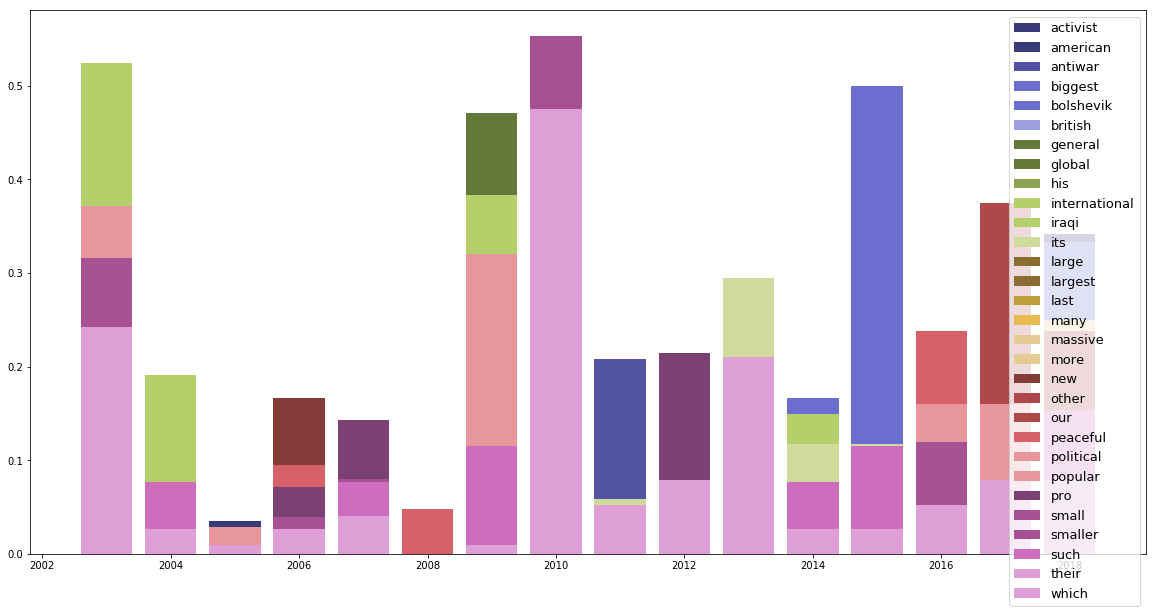

In [69]:
cmap = cm.get_cmap('tab20b', len(list(d.columns)[1:]))    # PiYG

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

plt.figure(figsize=(20, 10))

for c,city in enumerate(list(d.columns)[1:]):
    plt.bar(list(d['year']), list(d[city]), color=colors[c])

plt.legend(list(d.columns)[1:], loc='upper right',fontsize=13)

In [54]:
pd.DataFrame(list(dict(Counter(adjs)).items()),columns = ['id','size']).to_csv('adj-network-nodes.csv',index=False)